KM3Net example notebook
=======================

This notebook serves as an example of how to use the software provided by the KM3Net package.

We start with some import statements to see if everything is working correctly.

In [1]:
%matplotlib inline

import numpy
import matplotlib.pyplot as pyplot

from km3net.kernels import QuadraticDifferenceSparse, PurgingSparse
import km3net.util as util

print ("We're good to go!")

We're good to go!


Let's start with reading some input data. We assume the data is stored in a ASCI file, using four columns. The first column stores the time in nano seconds, column two through four store the x,y,z-coordinates of the hits. We assume that the input data is sorted on time, with the earliest hit first. Finally, we assume a file contains data from only one timeslice. For this we are going to use the [get_real_input_data](https://benvanwerkhoven.github.io/KM3Net/sphinxdoc/html/internal.html#km3net.util.get_real_input_data) utility function.

In [2]:
N,x,y,z,ct = util.get_real_input_data("sample.txt")
print ("Read", N, "hits from file")

Read 5000 hits from file


Before we continue, we have to initialize the GPU kernels used by the software. This means we have to instantiate the Python objects that will serve as an interface to our compiled GPU kernels and the data currently stored in the memory of the GPU.

In [3]:
context, cc = util.init_pycuda()
qd_kernel = QuadraticDifferenceSparse(N, cc=cc)
purging = PurgingSparse(N, cc)

The next step is of course start doing some computations. We want to compute all correlations between the hits we've just retrieved from a file. For this we use the 'qd_kernel' name we've just created to refer to the GPU Kernel that computes correlations based on the Quadratic Difference criterion and stores the result as a sparse matrix. We use the kernel by means of its [compute](https://benvanwerkhoven.github.io/KM3Net/sphinxdoc/html/internal.html#km3net-kernels-quadraticdifferencesparse) function.

In [4]:
d_col_idx, d_prefix_sums, d_degrees, total_hits = qd_kernel.compute(x, y, z, ct)

Now let's take a look at the data we got back from the GPU. We start by converting the sparse matrix stored on the GPU to a dense matrix stored on the host as a Numpy array. Then we make a quick plot of the correlation matrix.

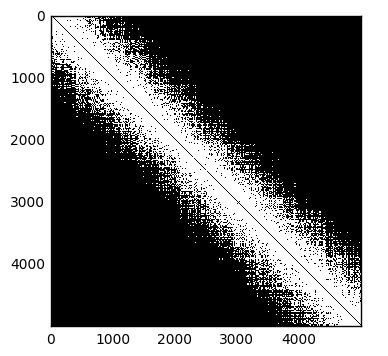

In [5]:
dense_matrix = util.sparse_to_dense(d_prefix_sums, d_col_idx, N, total_hits)

pyplot.imshow(dense_matrix, cmap=pyplot.cm.bone, interpolation='nearest')

The next step is of course to look for a group of hits that are all correlated with eachother. We approximate this clique using the purging algorithm. The implementation that we will use is the PurgingSparse GPU kernel that performs the purging algorithm directly on the sparsely stored correlation matrix in GPU memory.

We can call the GPU implementation of PurgingSparse using the name 'purging', which we created earlier. PurgingSparse implements a method called [compute](https://benvanwerkhoven.github.io/KM3Net/sphinxdoc/html/internal.html#km3net-kernels-purgingsparse), which we will use to compute the clique.

In [7]:
clique = purging.compute(d_col_idx, d_prefix_sums, d_degrees)
print("found clique of size", len(clique))
print(clique)

found clique of size 162
[3955 3986 3994 4008 4016 4023 4031 4041 4044 4046 4054 4060 4064 4065 4068
 4069 4072 4077 4079 4081 4084 4085 4088 4089 4093 4094 4095 4097 4098 4100
 4101 4102 4103 4104 4107 4110 4111 4112 4113 4114 4116 4118 4119 4121 4123
 4125 4126 4128 4129 4130 4131 4132 4133 4134 4135 4136 4139 4142 4143 4145
 4146 4147 4148 4149 4150 4151 4154 4155 4156 4157 4158 4159 4162 4163 4166
 4168 4170 4171 4172 4173 4174 4175 4177 4180 4181 4182 4185 4186 4188 4190
 4191 4192 4193 4194 4195 4196 4197 4199 4200 4203 4212 4214 4215 4216 4217
 4218 4219 4220 4221 4222 4223 4226 4227 4228 4229 4230 4231 4232 4234 4235
 4236 4237 4238 4239 4242 4244 4245 4246 4247 4252 4254 4259 4263 4264 4266
 4267 4268 4270 4271 4273 4274 4277 4280 4281 4285 4289 4292 4293 4307 4308
 4315 4316 4317 4319 4320 4325 4334 4341 4351 4378 4382 4404]


And that's it! This example has shown how to read input data from a file and call the two main components of the pipeline.